# <font color='blue'>This code implements Chapter II part B from Huij & Verbeek (2009)</font>
### Huij, J., & Verbeek, M. (2009). On the use of multifactor models to evaluate mutual fund performance. *Financial Management, 38*(1), 75-102.

Available from: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=906723 or https://www.jstor.org/stable/20486686

![Fama MacBeth procedure](Fama_MacBeth_procedure.png)

# Load mutual fund return data from csv

In [1]:
import numpy as np
import pandas as pd

# Read data into dataframe
data = pd.read_csv('fund_data_largest_500.csv', low_memory=False)

# Convert the 'caldt' to a Python datetime and then to the Fama-French date format (YYYYMM)
data['Date'] = pd.to_datetime(data['caldt'], format="%Y%m%d")
data['YYYYMM'] = data['Date'].dt.strftime('%Y%m').astype(int)

# Set multi-column index (YYYYMM and crsp_fundno), but keep original columns
data.set_index(['YYYYMM','crsp_fundno'], drop=False, inplace=True)

# Load the Fama-French series

In [2]:
#  Load the 5 Factor into dataframe
famafrench = pd.read_excel('FF.xlsx', index_col=0, skiprows=0)

#  Load the 5 Factor into dataframe
momentum = pd.read_csv('F-F_Momentum_Factor.CSV', skiprows=13, index_col=0)

# Left-join the momentum dataframe to the famafrench dataframe
famafrench = famafrench.merge(momentum, left_index=True, right_index=True, how='left')

# Rename the momentum column to "WML"
famafrench.rename(columns={"Mom":"WML"}, inplace=True)

# Make returns into decimals instead of percentages
famafrench = famafrench / 100
display(famafrench)

,Mkt-RF,SMB,HML,RMW,CMA,Sin-RF,RF,WML
Date,,,,,,,,
196307,-0.0039,-0.0045,-0.0094,0.0066,-0.0115,0.0214,0.0027,0.0100
196308,0.0507,-0.0082,0.0182,0.0040,-0.0040,0.0662,0.0025,0.0103
196309,-0.0157,-0.0048,0.0017,-0.0076,0.0024,0.0085,0.0027,0.0016
196310,0.0253,-0.0130,-0.0004,0.0275,-0.0224,-0.0087,0.0029,0.0314
196311,-0.0085,-0.0085,0.0170,-0.0045,0.0222,-0.0096,0.0027,-0.0075
...,...,...,...,...,...,...,...,...
202008,0.0763,-0.0094,-0.0294,0.0427,-0.0144,-0.0004,0.0001,0.0051
202009,-0.0363,0.0007,-0.0251,-0.0115,-0.0177,-0.1418,0.0001,0.0305
202010,-0.0210,0.0476,0.0403,-0.0060,-0.0053,-0.0120,0.0001,-0.0303


#Fama-French cumulative return plot (after 2000)

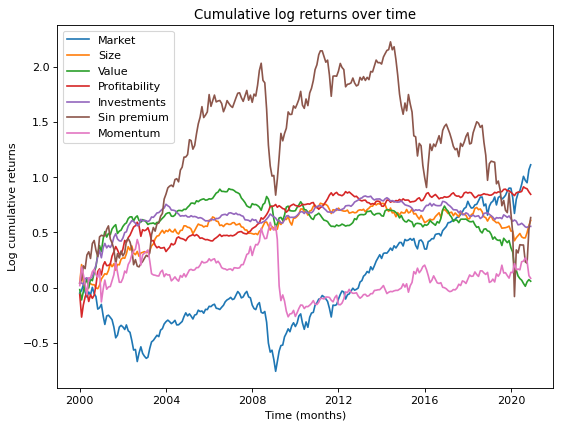

In [4]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

# Get sample period
famafrench_sample = famafrench[famafrench.index > 199912]

# Calculate cumulative returns on the dataframe
#famafrench_cumprod = np.cumprod(1 + famafrench_sample, axis=0) - 1   # Cumulative ARITHMETIC returns
famafrench_cumprod = np.cumsum(np.log(1 + famafrench_sample), axis=0)  # Cumulative LOG returns

# Add Python datetime to the dataframe (new column called "Date")
famafrench_cumprod['Date'] = pd.to_datetime(famafrench_sample.index, format="%Y%m")

# Plot the cumulative fama-french factors over time
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(famafrench_cumprod['Date'], famafrench_cumprod[['Mkt-RF','SMB','HML','RMW','CMA','Sin-RF','WML']])
plt.title('Cumulative log returns over time')
plt.legend(['Market','Size','Value','Profitability','Investments','Sin premium','Momentum'])
plt.xlabel('Time (months)')
plt.ylabel('Log cumulative returns')
plt.show()

# Step 1: Adding new variables to the mutual funds data (rolling regressions)

### Calculating the 3-year alpha, RMRF, SMB, HML, Sin-RF, and WML beta for each fund at each month

In [5]:
from tqdm.notebook import trange, tqdm
import sklearn.linear_model as lm

# Initialize list that is going to keep track of all our results
# I'm using a list here because that is the fastest object in Python!
# I also tried to directly save the results to the 'data' dataframe inside of the loops but that was 4x slower.
results = []

# Specify type of model
reg = lm.LinearRegression()

# Get the string representation of the months starting in 1992
dates = famafrench.index.unique()

# Starting index
lookback = 36     # Lookback period is 36 months (3 years)

# Loop over the dates
for period in trange(lookback, len(dates)):
    
    # Get the current date
    current_date = dates[period]
    
    # Get all dates of 36 months ago until last month
    lookback_period = dates[period-lookback:period]
    
    # Print some information
    print('Iteration {} at date {}, lookback period is {} to {} ({:.0f} months)'.format(
        period, current_date, lookback_period[0], lookback_period[-1], len(lookback_period)))
    
    # Get corresponding Fama-French data
    ff_history_index = famafrench.index.isin(lookback_period)
    ff_history = famafrench.loc[ff_history_index]
    
    # Get all funds at this period in time (in this iteration)
    funds_this_period_index = data.index.get_level_values('YYYYMM') == current_date
    funds_this_period = data.loc[funds_this_period_index, 'crsp_fundno'].unique()
    
    # Get all historical data for the funds that exist in this period in time
    funds_historical_data_index = np.logical_and(
        data.index.get_level_values('YYYYMM').isin(lookback_period),
        data.index.get_level_values('crsp_fundno').isin(funds_this_period)
    )
    funds_historical_data = data.loc[funds_historical_data_index]
    
    # Loop over all funds THIS PERIOD
    for fund in funds_this_period:
        
        # Get the row positions for the data for this fund   
        fund_data_index = funds_historical_data.index.get_level_values('crsp_fundno') == fund
        
        # Get the individual data for this fund
        # And make new index that corresponds to the ff_history index (this makes the merge below faster!)
        fund_data = funds_historical_data.loc[fund_data_index].set_index('YYYYMM')
        
        # If this specific fund has less than 20 observations, ignore it!
        if fund_data.shape[0] < 20:
            continue
        
        # Join the regression data together
        reg_data = ff_history.merge(fund_data['mret'], left_index=True, right_index=True, how='left')
        
        # Remove rows with no data
        reg_data = reg_data.dropna()
        
        # Calculate excess returns for the fund
        reg_data['Excess fund return'] = reg_data['mret'] - reg_data['RF']
            
        # Get the x-values for the regression
        x = reg_data[['Mkt-RF','SMB','HML','WML','Sin-RF']].values.reshape(reg_data.shape[0], 5)
        
        # Get the y-values for the regression
        y = reg_data['Excess fund return'].values.reshape(reg_data.shape[0], 1)
        
        # Fit regression
        reg.fit(x, y)
        
        # Append the calculations to our 'results' list
        # Note that the order in which we save the results matters! (see comment with [!!!] at the bottom of this code)
        
        results.append([current_date,          # YYYYMM
                        fund,                  # crsp_fundno
                        reg.intercept_[0],     # Alpha
                        reg.coef_[0][0],       # Market beta
                        reg.coef_[0][1],       # SMB beta
                        reg.coef_[0][2],       # HML beta
                        reg.coef_[0][3],       # WML beta
                        reg.coef_[0][4],       #Sin-RF beta
                       ])
        
# This is the end of the loops

# We now turn our 'results' list into a dataframe (so we can merge it with the 'data' dataframe below)
# [!!!] Note that we need to specify the order of the results using (the correct) column names
results = pd.DataFrame(results, columns=['YYYYMM','crsp_fundno','Alpha','Market beta','SMB beta','HML beta','WML beta','Sin-RF beta'])

# Create multi-index (so it matches the 'data' dataframe index)
results.set_index(['YYYYMM','crsp_fundno'], inplace=True)

# Final step: merge our results back into the original 'data' dataframe. The matching is done based on the multi-index!
data = data.merge(results, left_index=True, right_index=True, how='left')

# DONE! 
# We just added new data to each fund at each moment in time based on historical (36-month) regressions!

print('Done.')

Iteration 36 at date 196607, lookback period is 196307 to 196606 (36 months)
Iteration 37 at date 196608, lookback period is 196308 to 196607 (36 months)
Iteration 38 at date 196609, lookback period is 196309 to 196608 (36 months)
Iteration 39 at date 196610, lookback period is 196310 to 196609 (36 months)
Iteration 40 at date 196611, lookback period is 196311 to 196610 (36 months)
Iteration 41 at date 196612, lookback period is 196312 to 196611 (36 months)
Iteration 42 at date 196701, lookback period is 196401 to 196612 (36 months)
Iteration 43 at date 196702, lookback period is 196402 to 196701 (36 months)
Iteration 44 at date 196703, lookback period is 196403 to 196702 (36 months)
Iteration 45 at date 196704, lookback period is 196404 to 196703 (36 months)
Iteration 46 at date 196705, lookback period is 196405 to 196704 (36 months)
Iteration 47 at date 196706, lookback period is 196406 to 196705 (36 months)
Iteration 48 at date 196707, lookback period is 196407 to 196706 (36 months)

# Plot some of the new data for a random fund (data check)

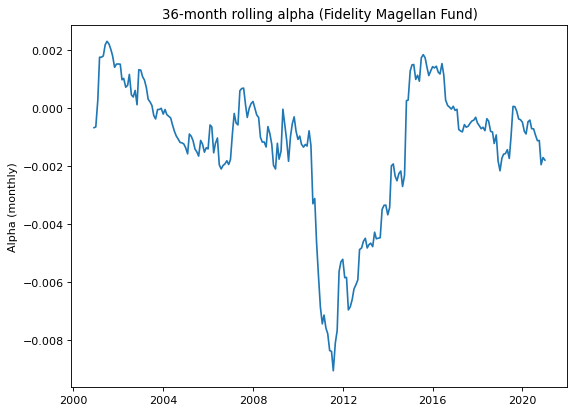

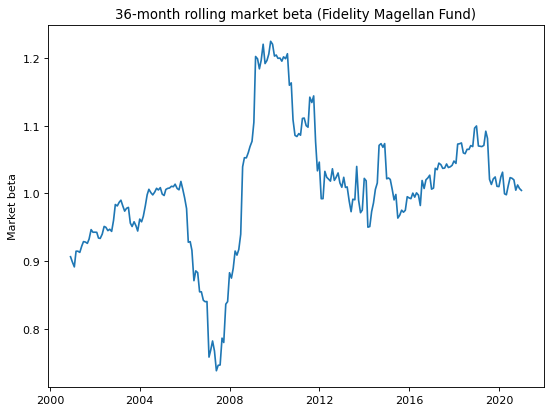

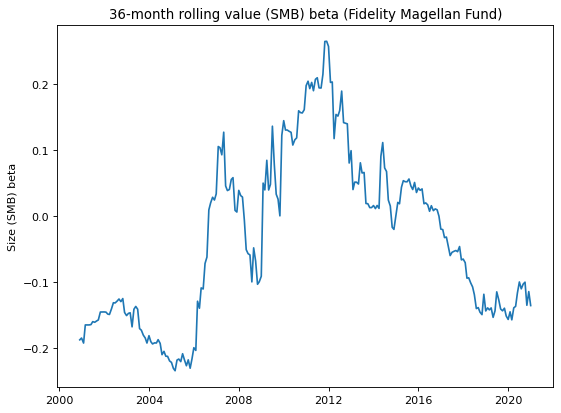

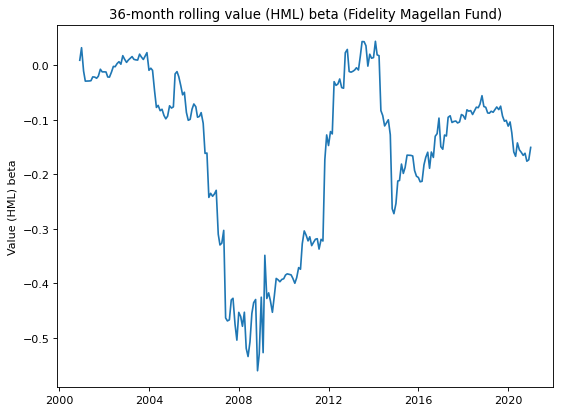

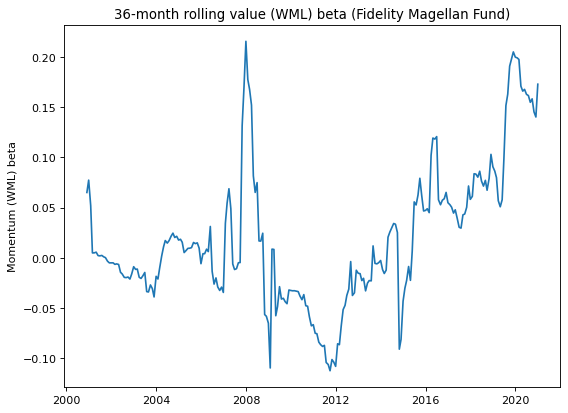

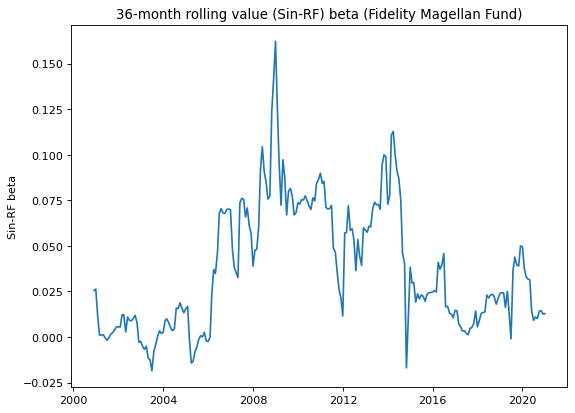

In [6]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

# Find fund by searching for its name
fund_name = 'Fidelity Magellan Fund'

# Get data in separate dataframe
fund = data.loc[data['fund_name'] == fund_name].copy()

# Plot the alpha
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fund['Date'], fund['Alpha'])
plt.title('36-month rolling alpha' + ' (' + fund_name + ')')
plt.ylabel('Alpha (monthly)')
plt.show()

# Plot the market beta
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fund['Date'], fund['Market beta'])
plt.title('36-month rolling market beta' + ' (' + fund_name + ')')
plt.ylabel('Market beta')
plt.show()

# Plot the SMB beta
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fund['Date'], fund['SMB beta'])
plt.title('36-month rolling value (SMB) beta' + ' (' + fund_name + ')')
plt.ylabel('Size (SMB) beta')
plt.show()

# Plot the HML beta
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fund['Date'], fund['HML beta'])
plt.title('36-month rolling value (HML) beta' + ' (' + fund_name + ')')
plt.ylabel('Value (HML) beta')
plt.show()

# Plot the WML beta
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fund['Date'], fund['WML beta'])
plt.title('36-month rolling value (WML) beta' + ' (' + fund_name + ')')
plt.ylabel('Momentum (WML) beta')
plt.show()

# Plot the SIn-RF beta
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fund['Date'], fund['Sin-RF beta'])
plt.title('36-month rolling value (Sin-RF) beta' + ' (' + fund_name + ')')
plt.ylabel('Sin-RF beta')
plt.show()

### Comparison to current Morningstar profile (Jan 2021)

https://www.morningstar.com/funds/xnas/fmagx/quote

![title](Magellan_fund_profile.png)

## Print the first 10.000 rows to Excel for manual inspection

In [5]:
# Print the first 10.000 rows to Excel for inspection:
data.head(10000).to_excel('Fund data with new attributes - for manual inspection.xlsx')

# Step 2: Creating a strategy based on mutual funds ("rank portfolios")
### Following Huij & Verbeek (2009), we create 10 quantile portfolios based on the funds' exposures to the factors. In the code below, we sort stocks based on their exposure to the Sin premium factor (Sin-RF). You can create rank portfolios based on any variable you like by changing the [rank_variable] setting.

In [7]:
# Settings
lookforward = 1                # Evaluation period is 1 month
rebalance = lookforward        # Rebalancing frequency is equal to lookforward period (in this case, every month)
number_quantiles = 10          # Number of quantile portfolios to create. For this example we will create 10 quantiles.
rank_variable = 'Sin-RF beta'     # Characteristic on which funds will be sorted into quantiles

# Get the string representation of the months starting in December 1992 (first rebalancing moment)
dates = famafrench.index.unique()

# Initialize results
quantile_portfolios = pd.DataFrame(data=None, index=dates, columns=range(0, number_quantiles))

# Specify type of model
reg = lm.LinearRegression()

# Loop over the dates
for period in trange(0, len(dates), rebalance):

    # Get the current date
    current_date = dates[period]
    
    # Get all dates of the next year (lookforward window)
    lookforward_period = dates[period+1:period+lookforward+1]
    
    # Get all funds at this period in time (in this iteration)
    funds_this_period_index = data.index.get_level_values('YYYYMM') == current_date
    funds_this_period = data.loc[funds_this_period_index]
    
    # If less than 100 funds in total, ignore the code below
    if funds_this_period[rank_variable].count() < 100:
        continue
    
    # Sort the funds into quantiles (using pandas 'qcut' function)
    quantiles_index = pd.qcut(funds_this_period[rank_variable], number_quantiles, labels=range(0, number_quantiles))
    
    # Loop over each quantile
    for q in range(0, number_quantiles):
        
        # Get the fund identifiers that are part of this quantile
        funds_in_quantile = quantiles_index.index.get_level_values('crsp_fundno')[quantiles_index == q]
        
        # Get the forward-looking returns of the funds that belong to this quantile
        fund_returns_index = np.logical_and(
            data.index.get_level_values('YYYYMM').isin(lookforward_period),
            data.index.get_level_values('crsp_fundno').isin(funds_in_quantile)
        )
        fund_returns = data.loc[fund_returns_index, 'mret']
        
        # Put the dates as columns (instead of having a multi-column index, make separate columns for each date)
        fund_returns = fund_returns.unstack(level='YYYYMM')
        
        # Define the weighting scheme.
        # For now, we will created equally-weighted quantile portfolios.
        # We assume that if a mutual fund closes, we can reinvest our redeemed money in the remaining funds.
        fund_weights = fund_returns.notna().astype(int)
        fund_weights = fund_weights.div(fund_weights.sum(axis=0), axis=1)
        
        # Multiply returns with weights to get the return of the quantile portfolio
        quantile_portfolio_return = (fund_returns * fund_weights).sum(axis=0, skipna=True)
        
        # Save the future returns for this quantile in the 'quantile_portfolios' dataframe
        quantile_portfolios_index = quantile_portfolios.index.isin(lookforward_period)
        quantile_portfolios.loc[quantile_portfolios_index, q] = quantile_portfolio_return
        
print('Quantile portfolios are created.')


Quantile portfolios are created.


### Plot cumulative returns of quantile portfolios

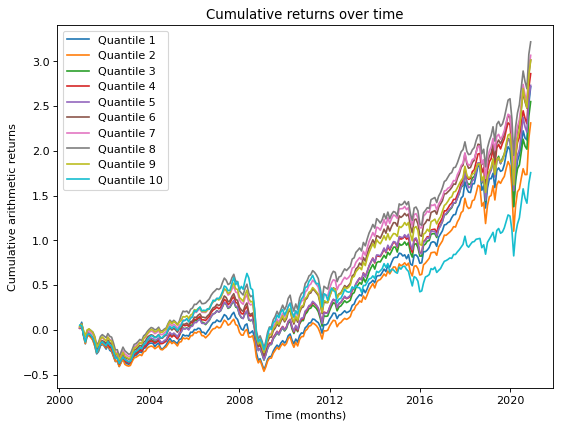

In [8]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

# Calculate cumulative log returns of quantile portfolios
quantile_portfolios_cumprod = np.cumprod(1 + quantile_portfolios, axis=0) - 1

# Add Python datetime to the dataframe (new column called "Date")
quantile_portfolios_cumprod['Date'] = pd.to_datetime(quantile_portfolios_cumprod.index, format="%Y%m")

# Plot the cumulative fama-french factors over time
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(quantile_portfolios_cumprod['Date'], quantile_portfolios_cumprod[range(0,number_quantiles)])
plt.title('Cumulative returns over time')
plt.legend(["Quantile {}".format(q) for q in range(1,number_quantiles+1)])
plt.xlabel('Time (months)')
plt.ylabel('Cumulative arithmetic returns')
plt.show()

# Step 3: Cross-sectional Fama and MacBeth (1973) regressions

## Calculating Fama-French regressions on the 10 quantile portfolios to get betas

In [9]:
import numpy as np
import statsmodels.api as sm

# Regression window is 36 months
historical_window = 36

# Specify portfolios to analyze
portfolios = quantile_portfolios

# Load Fama-French factors
ff = famafrench[famafrench.index.isin(portfolios.index)]

# Merge together
portfolios = portfolios.merge(ff, left_index=True, right_index=True, how='left')

# Get the string representation of the months starting in December 1992 (first rebalancing moment)
dates = portfolios.index.unique()

# Specify type of model
reg = lm.LinearRegression()

# Loop over the dates but skip the last date
for period in trange(historical_window, len(dates)-1, 1):
    
    # Get the dates of the previous 36 months
    lookback_period = dates[period-historical_window:period]
    
    # Get corresponding regression data
    lookback_index = portfolios.index.isin(lookback_period)
    lookback_data = portfolios.loc[lookback_index]
    
    # Loop over the 20 quantiles
    for q in range(0, number_quantiles):
        
        # Create name for this quantile
        quantile_name = "Q{}".format(q)
        
        # Get the data for this quantile
        regression_data = lookback_data[[q, 'Mkt-RF','SMB','HML','WML','Sin-RF','RF']].copy()
        
        # Remove rows with no data
        regression_data = regression_data.dropna()
        
        # If this specific quantile has less than 20 observations this period, ignore
        if regression_data.shape[0] < 20:
            continue
        
        # Calculate excess returns for the fund
        regression_data['Excess quantile return'] = regression_data[q] - regression_data['RF']
        
        ##############################
        ### Fama-French regression ###
        ##############################
        
        # Get the x-values for the regression
        x = regression_data[['Mkt-RF','SMB','HML','WML','Sin-RF']].values.reshape(regression_data.shape[0], 5)
        
        # Get the y-values for the regression
        y = regression_data['Excess quantile return'].values.reshape(regression_data.shape[0], 1)
        
        # Fit regression
        reg.fit(x, y)
        
        # Save the result back to the [portfolios] dataframe IN THE NEXT MONTH !!!
        index = (portfolios.index == dates[period+1])
        portfolios.loc[index, 'ExcRet_'   + quantile_name] = portfolios.loc[index, q] - portfolios.loc[index, 'RF']
        portfolios.loc[index, 'Alpha_'    + quantile_name] = reg.intercept_[0]  # Alpha (regression intercept)
        portfolios.loc[index, 'Beta_Mkt_' + quantile_name] = reg.coef_[0][0]    # Mkt beta
        portfolios.loc[index, 'Beta_SMB_' + quantile_name] = reg.coef_[0][1]    # SMB beta
        portfolios.loc[index, 'Beta_HML_' + quantile_name] = reg.coef_[0][2]    # HML beta
        portfolios.loc[index, 'Beta_WML_' + quantile_name] = reg.coef_[0][3]    # WML beta
        portfolios.loc[index,'Beta_Sin-RF_'+quantile_name]=reg.coef_[0][4]      #Sin-RF beta


### Print the quantile portfolios to Excel for further inspection

In [9]:
# Print all the data to Excel for manual inspection
portfolios.to_excel('Quantile data - for manual inspection.xlsx')

## Full-sample CAPM regressions on the quantile portfolios

In [10]:
# Specify type of model
reg = lm.LinearRegression()

# Initialize results
results = pd.DataFrame(data=None, index=['CAPM Alpha', 'CAPM Beta', 'Excess return'], columns=range(0, number_quantiles))

# Loop over the 20 quantiles
for q in range(0, number_quantiles):

    # Get regression data for this quantile
    regression_data = portfolios[['Mkt-RF', 'ExcRet_Q{}'.format(q)]]
    
    # Remove rows with no data
    regression_data = regression_data.dropna()
                                             
    # Get the x-values for the regression
    x = regression_data[['Mkt-RF']].values.reshape(regression_data.shape[0], 1)
    
    # Get the y-values for the regression
    y = regression_data['ExcRet_Q{}'.format(q)].values.reshape(regression_data.shape[0], 1)
    
    # Fit regression
    reg.fit(x, y)
                                            
    # Save results
    results.loc['CAPM Alpha', q] = reg.intercept_[0] * 12 * 100      # CAPM alpha (annualized)
    results.loc['CAPM Beta', q] = reg.coef_[0][0]                    # CAPM Beta
    results.loc['Excess return', q] = np.mean(y) * 12 * 100          # Excess returns (annualized)


## Plot annualized alphas (Figure 2 from Huij & Verbeek, 2009)

See https://www.jstor.org/stable/20486686

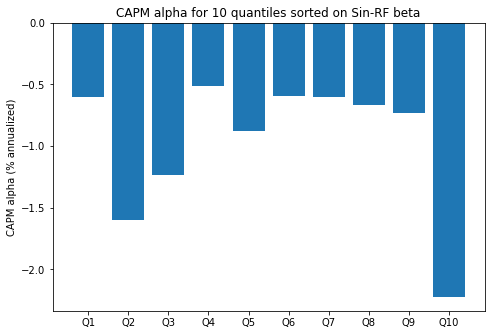

In [11]:
import matplotlib.pyplot as plt

# Initialize figure
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

# Add labels
labels = ["Q{}".format(q) for q in range(1, number_quantiles+1)]
alphas = results.loc['CAPM Alpha']

# Add the bars to the plot
ax.bar(labels, alphas)
plt.title('CAPM alpha for {} quantiles sorted on {}'.format(number_quantiles, rank_variable))
plt.ylabel('CAPM alpha (% annualized)')
plt.show()

## Plot excess returns (see Figure 1 of SSRN version of Huij & Verbeek, 2009)

See https://papers.ssrn.com/sol3/papers.cfm?abstract_id=906723

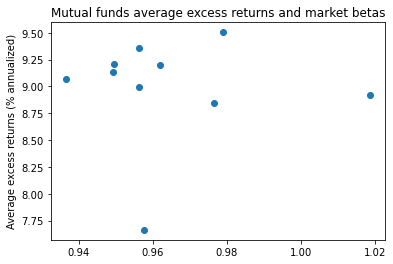

In [12]:
import matplotlib.pyplot as plt

# Initialize figure
fig = plt.figure()
plt.scatter(results.loc['CAPM Beta'], results.loc['Excess return'])
plt.title('Mutual funds'' average excess returns and market betas'.format(number_quantiles, rank_variable))
plt.ylabel('Average excess returns (% annualized)')
plt.show()

# Step 4: calculating the Fama-MacBeth (1973) regressions on the quantiles

### <font color='gray'>Note: we already lagged the betas by one month in the previous code</font>

In [13]:
# Get the string representation of the months starting in December 1992 (first rebalancing moment)
dates = portfolios.index.unique()

# Initialize results (we expect 4 factors)
fama_macbeth = pd.DataFrame(data=np.nan, index=portfolios.index, columns=['Gamma_Mkt', 'Gamma_SMB', 'Gamma_HML', 'Gamma_WML','Gamma_Sin-RF'])

# Specify type of model
reg = lm.LinearRegression(fit_intercept=False)

# For each cross-section, perform Fama-MacBeth regressions
for period in trange(0, len(dates), 1):
    
        # Get index of current date
        index = (portfolios.index == dates[period])
        
        # Get the dependent variable this period (excess returns)
        col_returns = ["ExcRet_Q{}".format(q) for q in range(0, number_quantiles)]
        
        # Get the y-values for the regression
        y = portfolios.loc[index, col_returns].values.reshape(len(col_returns), 1)
        
        # Get the regressors this period (the one-month lagged betas)
        col_beta_Mkt = ["Beta_Mkt_Q{}".format(q) for q in range(0, number_quantiles)]
        col_beta_SMB = ["Beta_SMB_Q{}".format(q) for q in range(0, number_quantiles)]
        col_beta_HML = ["Beta_HML_Q{}".format(q) for q in range(0, number_quantiles)]
        col_beta_WML = ["Beta_WML_Q{}".format(q) for q in range(0, number_quantiles)]
        col_beta_SinMRF=["Beta_Sin-RF_Q{}".format(q) for q in range(0, number_quantiles)]
        
        # Get the x-values for the regression
        beta_Mkt = portfolios.loc[index, col_beta_Mkt].values.reshape(number_quantiles, 1)
        beta_SMB = portfolios.loc[index, col_beta_SMB].values.reshape(number_quantiles, 1)
        beta_HML = portfolios.loc[index, col_beta_HML].values.reshape(number_quantiles, 1)
        beta_WML = portfolios.loc[index, col_beta_WML].values.reshape(number_quantiles, 1)
        beta_SinMRF=portfolios.loc[index, col_beta_SinMRF].values.reshape(number_quantiles, 1)
        
        # Merge regressors together
        x = np.concatenate([beta_Mkt, beta_SMB, beta_HML, beta_WML, beta_SinMRF], axis=1)
        
        # If no data in this cross-section, continue to next iteration
        if np.sum(~np.isnan(x)) == 0:
            continue
        
        # Fit regression
        reg.fit(x, y)
        
        # Save results
        fama_macbeth.loc[index, 'Gamma_Mkt'] = reg.coef_[0][0]
        fama_macbeth.loc[index, 'Gamma_SMB'] = reg.coef_[0][1]
        fama_macbeth.loc[index, 'Gamma_HML'] = reg.coef_[0][2]
        fama_macbeth.loc[index, 'Gamma_WML'] = reg.coef_[0][3]
        fama_macbeth.loc[index, 'Gamma_Sin-RF']=reg.coef_[0][4]
        

## Final result: estimating the Fama-MacBeth premiums

In [14]:
# Merge the [famafrench] dataframe back into the [fama_macbeth] dataframe
results = fama_macbeth.merge(famafrench, how='left', left_index=True, right_index=True)

# Print which variable the portfolios were sorted on:
print("\nWhen sorting on {}, the Fama-MacBeth premiums are as follows:\n".format(rank_variable))

# Calculate the time-series average Fama-MacBeth premiums
print(" > The time-series average Mkt premium for funds is: {:.2%} per month".format(results['Gamma_Mkt'].mean()))
print("   The hypothetical long-short premium on stocks is: {:.2%} per month".format(results['Mkt-RF'].mean()))
print("")
print(" > The time-series average SMB premium for funds is: {:.2%} per month".format(results['Gamma_SMB'].mean()))
print("   The hypothetical long-short premium on stocks is: {:.2%} per month".format(results['SMB'].mean()))
print("")
print(" > The time-series average HML premium for funds is: {:.2%} per month".format(results['Gamma_HML'].mean()))
print("   The hypothetical long-short premium on stocks is: {:.2%} per month".format(results['HML'].mean()))
print("")
print(" > The time-series average WML premium for funds is: {:.2%} per month".format(results['Gamma_WML'].mean()))
print("   The hypothetical long-short premium on stocks is: {:.2%} per month".format(results['WML'].mean()))
print("")
print(" > The time-series average Sin premium for funds is: {:.2%} per month".format(results['Gamma_Sin-RF'].mean()))
print("   The hypothetical long-short premium on stocks is: {:.2%} per month".format(results['Sin-RF'].mean()))
print("")


When sorting on Sin-RF beta, the Fama-MacBeth premiums are as follows:

 > The time-series average Mkt premium for funds is: 0.80% per month
   The hypothetical long-short premium on stocks is: 0.57% per month

 > The time-series average SMB premium for funds is: 0.17% per month
   The hypothetical long-short premium on stocks is: 0.23% per month

 > The time-series average HML premium for funds is: 0.35% per month
   The hypothetical long-short premium on stocks is: 0.25% per month

 > The time-series average WML premium for funds is: 0.52% per month
   The hypothetical long-short premium on stocks is: 0.64% per month

 > The time-series average Sin premium for funds is: 1.59% per month
   The hypothetical long-short premium on stocks is: 0.76% per month



## Estimating the correlation with the market factor (quick check)

In [15]:
# Merge the [famafrench] dataframe back into the [fama_macbeth] dataframe
results = fama_macbeth.merge(famafrench, how='left', left_index=True, right_index=True)

# Remove rows with missing data
results = results.dropna()

# Calculate correlations between the cross-sectional Sin-RF gamma and the Fama-French market factor
display(results[['Gamma_Sin-RF','Mkt-RF']].corr())

,Gamma_Sin-RF,Mkt-RF
Gamma_Sin-RF,1.000000,0.537381
Mkt-RF,0.537381,1.000000


## Calculating the significance of the premiums

In [16]:
# Calculating the average premium
means = results[['Gamma_Mkt','Gamma_SMB','Gamma_HML','Gamma_WML','Gamma_Sin-RF']].mean()

# Calculating the standard deviation
stdev = results[['Gamma_Mkt','Gamma_SMB','Gamma_HML','Gamma_WML','Gamma_Sin-RF']].std()

# Calculating the t-statistics
tstats = means / (stdev / np.sqrt(results.shape[0]))

# Showing the results
display(tstats)

Gamma_Mkt       2.706251
Gamma_SMB       0.471360
Gamma_HML       1.022293
Gamma_WML       0.955124
Gamma_Sin-RF    1.321257
dtype: float64